## XGBoost Model for OSM Changeset Data

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

### Create directories required for the code

In [9]:
import os

# Define the directory and file path for saving the model
save_dir = '../saved_parameters/changeset_model/'
model_file = os.path.join(save_dir, 'final_xgboost_model.pkl')

# Check if the directory exists, else create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Directory created at: {save_dir}")
else:
    print(f"Directory already exists at: {save_dir}")

Directory already exists at: ../saved_parameters/changeset_model/


### Load the data set into a data frame

In [10]:
features_df = pd.read_parquet("../data/changeset_data/osm_labelled_changeset_features_with_user_info.parquet")

#Shuffle the data entries
features_df = features_df.sample(frac=1, random_state=42).reset_index(drop=True)
features_df.head()

,changeset_id,created_at,closed_at,user,user_id,num_changes,min_lat,min_lon,max_lat,max_lon,...,label,no_nodes,no_ways,no_relations,no_creates,no_modifications,no_deletions,uid,account_created,changes_count
0,55841613,2018-01-28 21:16:49+00:00,2018-01-28 21:16:49+00:00,clauslide,7528900,1,-33.546025,-71.606199,-33.545570,-71.605570,...,True,0,1,0,1,0,0,7528900,2018-01-26T06:58:01Z,0
1,45459256,2017-01-25 03:29:43+00:00,2017-01-25 03:29:44+00:00,Eye of the Squid,5186084,5,43.779429,-79.337066,43.780136,-79.336516,...,True,4,1,0,5,0,0,5186084,2017-01-25T02:47:25Z,0
2,31041378,2015-05-12 09:18:59+00:00,2015-05-12 09:18:59+00:00,maartinez,1738975,1,53.661516,14.608453,53.663647,14.609384,...,False,0,1,0,0,1,0,1738975,2013-09-09T09:10:27Z,0
3,58344034,2018-04-23 16:22:00+00:00,2018-04-23 16:22:00+00:00,dankpoet,4175482,5,12.129619,99.002683,12.129719,99.002799,...,False,4,1,0,5,0,0,4175482,2016-06-26T22:16:00Z,0
4,25666885,2014-09-25 14:45:21+00:00,2014-09-25 14:45:22+00:00,wsay22,1464076,1,54.778566,9.438529,54.778566,9.438529,...,True,1,0,0,0,1,0,1464076,2013-05-19T09:12:59Z,0


### Drop unnecessary columns and replace spaces with underscores

In [11]:
if features_df.columns.__contains__('geometry'):
    features_df.drop('geometry', axis=1, inplace=True)

if features_df.columns.__contains__('changeset_id'):
    features_df.drop('changeset_id', axis=1, inplace=True)

if features_df.columns.__contains__('created_at'):
    features_df.drop('created_at', axis=1, inplace=True)

if features_df.columns.__contains__('user'):
    features_df.drop('user', axis=1, inplace=True)
    
#TODO: Analyse comment and detect if suspicious. Can get a new feature like comment suspicious score.
if features_df.columns.__contains__('comment'):
    features_df.drop('comment', axis=1, inplace=True)

if features_df.columns.__contains__('uid'):
    features_df.drop('uid', axis=1, inplace=True)

if features_df.columns.__contains__('changes_count'):
    features_df.drop('changes_count', axis=1, inplace=True)

features_df.columns = features_df.columns.str.replace(' ', '_', regex=True)

#TODO: Also add user features or user reliability score.
#TODO: Also check about previous object features.

features_df.head()

,closed_at,user_id,num_changes,min_lat,min_lon,max_lat,max_lon,created_by,label,no_nodes,no_ways,no_relations,no_creates,no_modifications,no_deletions,account_created
0,2018-01-28 21:16:49+00:00,7528900,1,-33.546025,-71.606199,-33.545570,-71.605570,iD 2.6.0,True,0,1,0,1,0,0,2018-01-26T06:58:01Z
1,2017-01-25 03:29:44+00:00,5186084,5,43.779429,-79.337066,43.780136,-79.336516,iD 2.0.2,True,4,1,0,5,0,0,2017-01-25T02:47:25Z
2,2015-05-12 09:18:59+00:00,1738975,1,53.661516,14.608453,53.663647,14.609384,iD 1.7.2,False,0,1,0,0,1,0,2013-09-09T09:10:27Z
3,2018-04-23 16:22:00+00:00,4175482,5,12.129619,99.002683,12.129719,99.002799,iD 2.8.0,False,4,1,0,5,0,0,2016-06-26T22:16:00Z
4,2014-09-25 14:45:22+00:00,1464076,1,54.778566,9.438529,54.778566,9.438529,iD 1.5.4,True,1,0,0,0,1,0,2013-05-19T09:12:59Z


### One-hot Encoding

In [12]:
# filtered_changesets = features_df[features_df['changeset_id'] == 31867220]
# 
# Print the resulting DataFrame
# filtered_changesets.head()

In [13]:
X = features_df.drop('label', axis=1).copy()
y = features_df['label'].copy()

X['closed_at'] = pd.to_datetime(X['closed_at']).astype(int) / 10**9
X['account_created'] = pd.to_datetime(X['account_created']).astype(int) / 10**9

X_encoded = pd.get_dummies(X, columns=['created_by'])

assert X_encoded.dtypes.__contains__('object') == False
X_encoded.head()

,closed_at,user_id,num_changes,min_lat,min_lon,max_lat,max_lon,no_nodes,no_ways,no_relations,...,created_by_reverter;JOSM/1.5 (14945 uk),created_by_reverter_plugin/34977;JOSM/1.5 (15031 en),created_by_reverter_plugin/34999;JOSM/1.5 (15155 de),created_by_reverter_plugin/35084;JOSM/1.5 (15492 en),created_by_rocketdata.io,created_by_rosemary v0.3.12,created_by_rosemary v0.4.4,created_by_simple_revert.py,created_by_streetkeysmv,created_by_upload.py v. 1
0,1.517174e+09,7528900,1,-33.546025,-71.606199,-33.545570,-71.605570,0,1,0,...,False,False,False,False,False,False,False,False,False,False
1,1.485315e+09,5186084,5,43.779429,-79.337066,43.780136,-79.336516,4,1,0,...,False,False,False,False,False,False,False,False,False,False
2,1.431422e+09,1738975,1,53.661516,14.608453,53.663647,14.609384,0,1,0,...,False,False,False,False,False,False,False,False,False,False
3,1.524501e+09,4175482,5,12.129619,99.002683,12.129719,99.002799,4,1,0,...,False,False,False,False,False,False,False,False,False,False
4,1.411656e+09,1464076,1,54.778566,9.438529,54.778566,9.438529,1,0,0,...,False,False,False,False,False,False,False,False,False,False


### Format y and check ratio of x:y

In [14]:
y = y.replace(True, 1)
y = y.replace(False, 0)
sum(y) / len(y)

C:\Users\saise\AppData\Local\Temp\ipykernel_36572\1318066108.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(False, 0)


0.500905051834787

### Split the data between train and test set & print statistics

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, test_size=0.4, stratify=y)

# Get the shapes of the datasets
shapes = {
    'X_train shape': X_train.shape,
    'X_test shape': X_test.shape,
    'y_train shape': y_train.shape,
    'y_test shape': y_test.shape
}

# Convert shapes to DataFrame for better display
shapes_df = pd.DataFrame(shapes, index=['Number of Samples', 'Number of Features']).T
print(shapes_df)
print()

# 1. Calculate the total number of samples in train and test sets
total_train = len(y_train)
total_test = len(y_test)

# 2. Calculate the number of vandalism (assuming 'vandalism' is labeled as 1)
vandalism_train = sum(y_train)
vandalism_test = sum(y_test)

# 3. Calculate the number of non-vandalism (assuming 'non-vandalism' is labeled as 0)
non_vandalism_train = total_train - vandalism_train
non_vandalism_test = total_test - vandalism_test

# 4. Print the statistics
print(f"Train Set Statistics:\n"
      f"Total: {total_train}\n"
      f"Vandalism: {vandalism_train}\n"
      f"Non-Vandalism: {non_vandalism_train}\n")

print(f"Test Set Statistics:\n"
      f"Total: {total_test}\n"
      f"Vandalism: {vandalism_test}\n"
      f"Non-Vandalism: {non_vandalism_test}\n")

print("sum(y_train)/len(y_train): " + str(sum(y_train) / len(y_train)))
print("sum(y_test)/len(y_test): " + str(sum(y_test) / len(y_test)))


               Number of Samples  Number of Features
X_train shape              10938                1459
X_test shape                7293                1459
y_train shape              10938               10938
y_test shape                7293                7293

Train Set Statistics:
Total: 10938
Vandalism: 5479
Non-Vandalism: 5459

Test Set Statistics:
Total: 7293
Vandalism: 3653
Non-Vandalism: 3640

sum(y_train)/len(y_train): 0.500914243920278
sum(y_test)/len(y_test): 0.5008912655971479


### Model training with random hyperparameters and without cross validation

In [16]:
from model.xgboost_training import train_final_model, save_model
from model.hyper_parameter_search import get_random_parameters

random_parameters = get_random_parameters()

# Train Final Model with random parameters
final_base_model = train_final_model(X_train, y_train, X_test, y_test, random_parameters)

# Save the Model
save_model(final_base_model, '../saved_parameters/changeset_model/final_xgboost_base_model.pkl')

Random Hyperparameters Generated: 

{'learning_rate': 0.2, 'max_depth': 5, 'subsample': 1.0, 'colsample_bytree': 0.7, 'lambda': 10, 'alpha': 5, 'min_child_weight': 3, 'gamma': 3, 'n_estimators': 100}



2024-11-06 19:15:56 - INFO - xgboost_training.py -- Model training complete.

2024-11-06 19:15:56 - INFO - xgboost_training.py -- Model saved to ../saved_parameters/changeset_model/final_xgboost_base_model.pkl


### Base model evaluation


Train Set Evaluation
--------------------

Accuracy: 0.8577436460047541
AUC-ROC: 0.9313909048256694

Classification Report (Train):
                precision    recall  f1-score   support

Not Vandalism       0.85      0.87      0.86      5459
    Vandalism       0.86      0.85      0.86      5479

     accuracy                           0.86     10938
    macro avg       0.86      0.86      0.86     10938
 weighted avg       0.86      0.86      0.86     10938


Test Set Evaluation
-------------------

Accuracy: 0.835047305635541
AUC-ROC: 0.9109305764041599

Classification Report (Test):
                precision    recall  f1-score   support

Not Vandalism       0.83      0.85      0.84      3640
    Vandalism       0.84      0.82      0.83      3653

     accuracy                           0.84      7293
    macro avg       0.84      0.84      0.84      7293
 weighted avg       0.84      0.84      0.84      7293


AUC-PR Score on Test Set: 0.913773442751916
ROC-AUC Score on Test Set

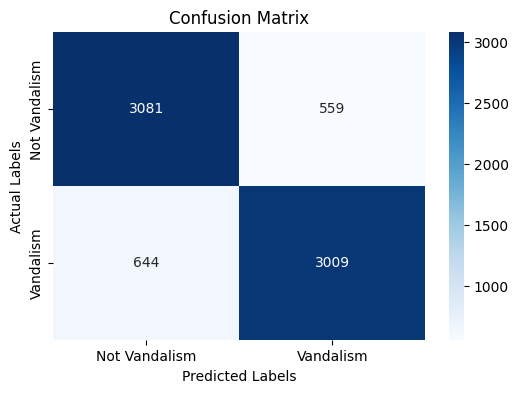

In [17]:
from evaluate_xgboost_model import (evaluate_train_test_metrics, calculate_auc_scores,
                                    plot_confusion_matrix)

# Evaluate Train and Test Metrics
y_test_pred, y_test_prob = evaluate_train_test_metrics(final_base_model, X_train, y_train, X_test, y_test)

# Calculate AUC Scores and Get Confusion Matrix
cm = calculate_auc_scores(y_test, y_test_pred, y_test_prob)

# Plot Confusion Matrix
plot_confusion_matrix(cm)

### Hyperparameter tuning with cross validation and model training with best parameters

In [18]:
from model.hyper_parameter_search import randomized_search_cv
from model.xgboost_training import train_final_model, save_model
from model.evaluate_xgboost_model import evaluate_model_with_cv

# Search and Load Hyperparameters
best_params = randomized_search_cv(X_train, y_train,  '../saved_parameters/changeset_model/best_hyperparameters.json')

# Train Final Model with best_params
final_tuned_model = train_final_model(X_train, y_train, X_test, y_test, best_params)

# (OPTIONAL): Perform Final Cross-Validation on Full Dataset
cv_scores = evaluate_model_with_cv(X_train, y_train, best_params)

# Save the Model
save_model(final_tuned_model, '../saved_parameters/changeset_model/final_xgboost_model_tuned.pkl')



2024-11-06 19:15:58 - INFO - hyper_parameter_search.py -- Hyperparameters file already exists.

2024-11-06 19:15:58 - INFO - load_hyper_parameters.py -- Loaded hyperparameters from ../saved_parameters/changeset_model/best_hyperparameters.json

2024-11-06 19:15:58 - INFO - hyper_parameter_search.py -- best hyper parameters: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'lambda': 0, 'gamma': 1, 'colsample_bytree': 1.0, 'alpha': 1}

2024-11-06 19:16:05 - INFO - xgboost_training.py -- Model training complete.



Performing 5-fold Cross-Validation on the entire data...



2024-11-06 19:16:21 - INFO - xgboost_training.py -- Model saved to ../saved_parameters/changeset_model/final_xgboost_model_tuned.pkl


Cross-Validation AUC Scores: [0.95181696 0.93437174 0.94075777 0.94060247 0.9434156 ]
Mean AUC Score: 0.942192909514605
Standard Deviation of AUC Scores: 0.005654682838202514


### Tuned model evaluation


Train Set Evaluation
--------------------

Accuracy: 0.9370085938928506
AUC-ROC: 0.9842428555585732

Classification Report (Train):
                precision    recall  f1-score   support

Not Vandalism       0.93      0.94      0.94      5459
    Vandalism       0.94      0.93      0.94      5479

     accuracy                           0.94     10938
    macro avg       0.94      0.94      0.94     10938
 weighted avg       0.94      0.94      0.94     10938


Test Set Evaluation
-------------------

Accuracy: 0.8782394076511724
AUC-ROC: 0.9481692752908191

Classification Report (Test):
                precision    recall  f1-score   support

Not Vandalism       0.87      0.89      0.88      3640
    Vandalism       0.89      0.87      0.88      3653

     accuracy                           0.88      7293
    macro avg       0.88      0.88      0.88      7293
 weighted avg       0.88      0.88      0.88      7293


AUC-PR Score on Test Set: 0.9513355988291211
ROC-AUC Score on Test S

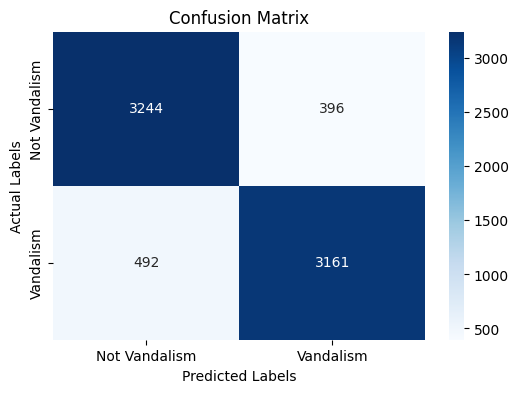

In [19]:
from evaluate_xgboost_model import (evaluate_train_test_metrics, calculate_auc_scores,
                                    plot_confusion_matrix)

# Evaluate Train and Test Metrics
y_test_pred, y_test_prob = evaluate_train_test_metrics(final_tuned_model, X_train, y_train, X_test, y_test)

# Calculate AUC Scores and Get Confusion Matrix
cm = calculate_auc_scores(y_test, y_test_pred, y_test_prob)

# Plot Confusion Matrix
plot_confusion_matrix(cm)